<h2>ToDo</h2>
<ul>
    <li>obtain r from multi-synapse model</li>
    <li>check, whether additive model makes sense (and whether hierarchical inference is even in here?!)</li>
    <li>ask for estimate of layer borders (current density estimate) and implement</li>
    <li>include fraction of silent neurons (~70% in CTKO, ~30% in WT, all exc, not much data in inhib)</li>
    <li>run inference without layers -> any effect between WT and cTKO?</li>
    <li>find if there is an effect on NMDA (ratio, timeconstant. ...)</li>
    <li>implement slicing data along up/down states</li>
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import os, sys

In [2]:
root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)
from empirical.readData import *
from inference.run_inference import *
from DM_theory import *

In [3]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import ipywidgets as widgets

<h1>Data preprocessing</h1>
<p>Data can be read in from three different sources by according functions:
<ul>
    <li><code>xlsx_data</code>: empirical data from excel</li>
    <li><code>mat_data</code>: empirical data from mat-file</li>
    <li><code>artificial_data</code>: artificially generated data</li>
</ul>
The final data will contain a multi-dimensional array of firing rates with the format:
<pre>[animal type X number animals X number layers X number clusters X number neurons]</pre>
</p>

In [4]:
mP_Ca = ModelParams('empirical',filePath='../../data/BuscheLab/spiking_data_for_modeling_with_depth.mat',plot=True)
mP = ModelParams('empirical',filePath='../../data/BuscheLab/2P_data.xlsx',include_silent=False)
mP_withSilent = ModelParams('empirical',filePath='../../data/BuscheLab/2P_data.xlsx',include_silent=True)

<h1>Model definition</h1>

In [5]:
##### currently issues: ~99% of traces diverge -> pole is difficult to fit
trace = run_on_data(mP,draws=5000,tune=10000,loadPath='results_xls_noSilent.nc')
trace_silent = run_on_data(mP_withSilent,draws=5000,tune=10000,loadPath='results_xls_trace.nc')
trace_Ca = run_on_data(mP_Ca,draws=5000,tune=10000,loadPath='results_Ca_trace.nc')
traces = [trace,trace_silent,trace_Ca]

In [11]:
##### currently issues: ~99% of traces diverge -> pole is difficult to fit
trace = run_on_data(mP,draws=5000,tune=10000,savePath='results_xls_noSilent.nc')
trace_silent = run_on_data(mP_withSilent,draws=5000,tune=10000,savePath='results_xls_trace.nc')
#trace_Ca = run_on_data(mP_Ca,draws=5000,tune=10000,loadPath='results_Ca_trace.nc',)


gamma shape __str__ = [370  13   1   1]
delta shape __str__ = [370  13   1   1]
nu __str__ = [370  13   1   1]
logP minimum __str__ = -3.5173483993886046
logP minimum __str__ = -3.5173483993886046
logP minimum __str__ = -3.5173483993886046


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_max, sigma_nu_max, mu_nu_max, delta, delta_delta_layer, delta_base, sigma_delta, gamma, delta_gamma_layer, gamma_base, sigma_gamma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 595 seconds.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


gamma shape __str__ = [370  13   1   1]
delta shape __str__ = [370  13   1   1]
nu __str__ = [370  13   1   1]
logP minimum __str__ = -3.5173483993886046
logP minimum __str__ = -3.5173483993886046
logP minimum __str__ = -3.5173483993886046


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_max, sigma_nu_max, mu_nu_max, delta, delta_delta_layer, delta_base, sigma_delta, gamma, delta_gamma_layer, gamma_base, sigma_gamma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 4396 seconds.
There were 4668 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.686578151578539, but should be close to 0.8. Try to increase the number of tuning steps.
There were 519 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.4891683345841674e-16, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3088 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
traces = [trace,trace_silent]

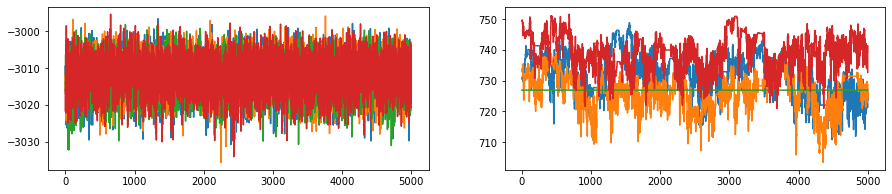

In [13]:
fig,ax = plt.subplots(1,len(traces),figsize=(15,3))
if len(traces)==1:
    ax = [ax]
for j,t in enumerate(traces):
    for i in range(4):
        ax[j].plot(t.log_likelihood['logP'][i,:,0])

<h1>Display results</h1>

In [14]:
def post_inference(mP,trace):
    
    paras = ['gamma','delta','nu_max']
    
    results = {}
    for p in paras:
        
        results[p] = {}
        results[p]['mean'] = trace['posterior'][p].values.mean(axis=(0,1))
        results[p]['std'] = trace['posterior'][p].values.std(axis=(0,1))
        
    results['N'] = mP.mask.sum(axis=0)
    
    return results

results = post_inference(mP,trace)
results_silent = post_inference(mP_withSilent,trace_silent)
#results_Ca = post_inference(mP_Ca,trace_Ca)

In [16]:
np.squeeze(results['nu_max']['mean'])

array([39.73531779, 36.58446298, 39.22070066, 43.41605063, 42.34262525,
       46.35963216, 42.68094176, 39.27246018, 35.75247859, 27.59935802,
       39.95362984, 35.79551386, 36.930396  ])

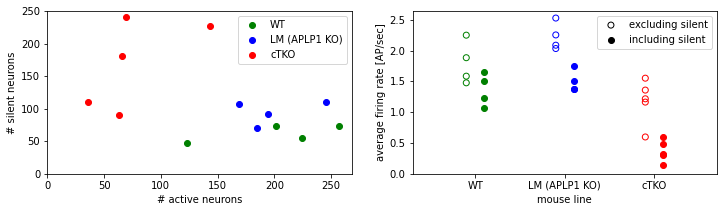

In [17]:
#def plot_numbers(ax,mP,results,str_title='',offset=0.1):

offset=0.1
fig,ax = plt.subplots(1,2,figsize=(12,3))

fr = np.nanmean(mP.spikes_raw,axis=(-1))

if mP._num_clusters>1:
    fr_data_exc = []
    fr_data_inh = []

    for l in range(mP._num_layers):
        ax[0].scatter(results['N'][:,l,1],results['N'][:,l,0],label=f'layer {l+1}')

        fr_data_exc.append(fr[~np.isnan(fr[:,l,0]),l,0])
        fr_data_inh.append(fr[~np.isnan(fr[:,l,1]),l,1])

    ax[1].boxplot(fr_data_exc,positions=np.arange(3)-0.1,widths=0.2,notch=True,patch_artist=True,
                boxprops=dict(color='k'),
             flierprops=dict(color='k', markeredgecolor='k'))
    ax[1].boxplot(fr_data_inh,positions=np.arange(3)+0.1,widths=0.2,notch=True,patch_artist=True,
            boxprops=dict(facecolor='r', color='r'),
             flierprops=dict(color='r', markeredgecolor='r'))

    plt.setp(ax[0],xlabel='# inhibitory neurons',ylabel='# excitatory neurons')
    plt.setp(ax[1],xticks=np.arange(3),xticklabels=np.arange(1,4),
            xlabel='layer',ylabel='average firing rate [AP/sec]')

else:

    col = ['g','b','r']
    fr = np.array([np.nanmean(row[row>0]) for row in np.squeeze(mP.spikes_raw)])
    results['fr'] = fr
    
    fr_withSilence = np.array([np.nanmean(row[row>0]) for row in np.squeeze(mP_withSilent.spikes_raw)])
    results_silent['fr'] = fr_withSilence
    
    silence = np.squeeze(mP.spikes_raw==0).sum(-1)
    for i,t in enumerate(mP.types):
        idx_type = mP.type==i

        
        ax[0].scatter(results['N'][idx_type],silence[idx_type],color=col[i],label=t)

        ax[1].scatter(np.array([i]*len(fr[idx_type])).astype('float')-offset,fr[idx_type],color=col[i],facecolor='none')
        ax[1].scatter(np.array([i]*len(fr[idx_type])).astype('float')+offset,fr_withSilence[idx_type],color=col[i])
        #ax[1].boxplot(fr[idx_type],positions=[i],notch=True,patch_artist=True,boxprops=dict(facecolor=col[i],color=col[i]))

    plt.setp(ax[0],xlim=[0,ax[0].get_xlim()[1]],ylim=[0,ax[0].get_ylim()[1]],
                xlabel='# active neurons',ylabel='# silent neurons')
    ax[0].legend()
    
    ax[1].scatter(np.NaN,np.NaN,color='k',facecolor='none',label='excluding silent')
    ax[1].scatter(np.NaN,np.NaN,color='k',label='including silent')

    ax[1].legend()
    #else:
        #ax[0].remove()
    plt.setp(ax[1],xlim=[-0.7,2.7],ylim=[0,ax[1].get_ylim()[1]],xticks=np.arange(3),xticklabels=mP.types,
                xlabel='mouse line',ylabel='average firing rate [AP/sec]')

#plt.suptitle(str_title)
    


#plot_numbers(ax,mP,results,'without silence',-0.1)
#plot_numbers(ax,mP_withSilent,results_silent,'with silence',0.1)
plt.show()

In [18]:
results['nu_max']['mean']

array([[[39.73531779]],

       [[36.58446298]],

       [[39.22070066]],

       [[43.41605063]],

       [[42.34262525]],

       [[46.35963216]],

       [[42.68094176]],

       [[39.27246018]],

       [[35.75247859]],

       [[27.59935802]],

       [[39.95362984]],

       [[35.79551386]],

       [[36.930396  ]]])

In [27]:
import math
import numpy as np
from general.helper import *
def sigma_V(nu=1., J_0=-1., tau_M=0.01, tau_A=0.005, tau_N=0.2, r = 0.5):
    J = J_0 * tau_M
    
    return J**2 * nu / (tau_A + tau_M) * ( (1-r)**2/2 + ((1-r)*r * tau_A)/(tau_A + tau_N) ) + \
            J**2 * nu / (tau_N + tau_M) * ( r**2/2 + (1-r)*r * tau_N / (tau_A + tau_N) )

def sigma_V_dot(nu=1., J_0=-1., tau_M=0.01, tau_A=0.005, tau_N=0.2, r = 0.5):
    J = J_0 * tau_M
    
    return 1./(tau_A * tau_M) * J**2 * nu / (tau_A + tau_M) * ( (1-r)**2/2 + ((1-r)*r * tau_A)/(tau_A + tau_N) ) + \
            1./(tau_N * tau_M) * J**2 * nu / (tau_N + tau_M) * ( r**2/2 + (1-r)*r * tau_N / (tau_A + tau_N) )

def nu_max(**kwargs):
    return 1/(2*math.pi) * np.sqrt(sigma_V_dot(**kwargs)/sigma_V(**kwargs))

def solve_nu_max(x,args):    
    empiric = args[0]
    vals = args[1]
    
    return nu_max(r=x,**args[1])-args[0]

Roots:  [array([0.95434918]), array([0.95434918, 0.95119994]), array([0.95434918, 0.95119994, 0.95315948]), array([0.95434918, 0.95119994, 0.95315948])]
Roots:  [array([0.92973665]), array([0.92973665]), array([0.92973665, 0.93668502]), array([0.92973665, 0.93668502, 0.94220162])]
Roots:  [array([0.89002585]), array([0.89002585, 0.91951433]), array([0.89002585, 0.91951433]), array([0.89002585, 0.91951433, 0.92284483]), array([0.89002585, 0.91951433, 0.92284483])]


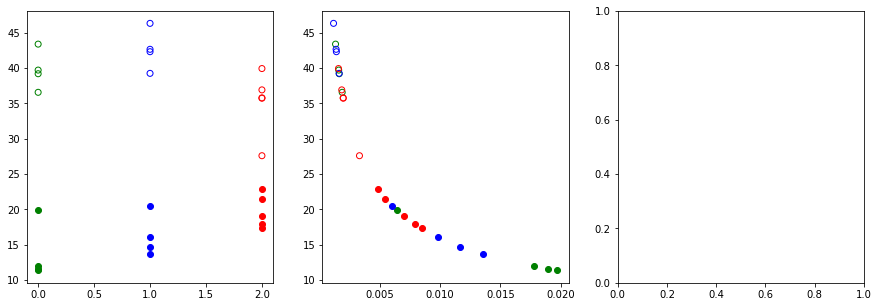

In [45]:
col = ['g','b','r']

fig,ax = plt.subplots(1,3,figsize=(15,5))
for i,t in enumerate(mP.types):
    idx_type = mP.type==i
    
    #nu_max = results_silent['nu_max']['mean'][idx_type]
    tau_m = 0.01
    
    ax[0].scatter(np.array([i]*len(fr[idx_type])).astype('float'),results['nu_max']['mean'][idx_type],color=col[i],facecolor='none',label=t)
    
    ax[0].scatter(np.array([i]*len(fr[idx_type])).astype('float'),results_silent['nu_max']['mean'][idx_type],color=col[i],label=t)
    
    tau_I = get_tau_I(results['nu_max']['mean'][idx_type],tau_m=tau_m)
    ax[1].scatter(tau_I,results['nu_max']['mean'][idx_type],color=col[i],facecolor='none')
    tau_I = get_tau_I(results_silent['nu_max']['mean'][idx_type],tau_m=tau_m)
    ax[1].scatter(tau_I,results_silent['nu_max']['mean'][idx_type],color=col[i])
    
    r = RootFinder(-1, 1, 0.1)
    #args = (19,{'tau_A':0.005})
    roots = [r.find(solve_nu_max, (np.squeeze(nu_m),{'tau_A':0.001})) for nu_m in results_silent['nu_max']['mean'][idx_type]]
    #root = r.find(solve_nu_max, (40,{'tau_A':0.001}))
    #roots = [root for root in roots if 0<root<1]
    print("Roots: ", roots)
    #print("Roots: ", root)

plt.show()

In [77]:
results_silent['nu_max']

{'mean': array([[19.72031109]]), 'std': array([[0.16191417]])}

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

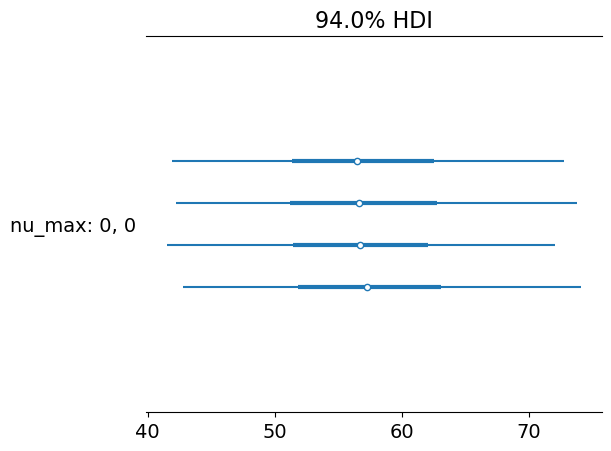

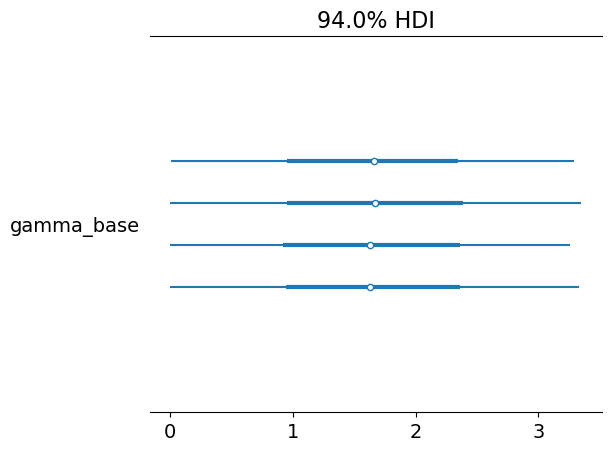

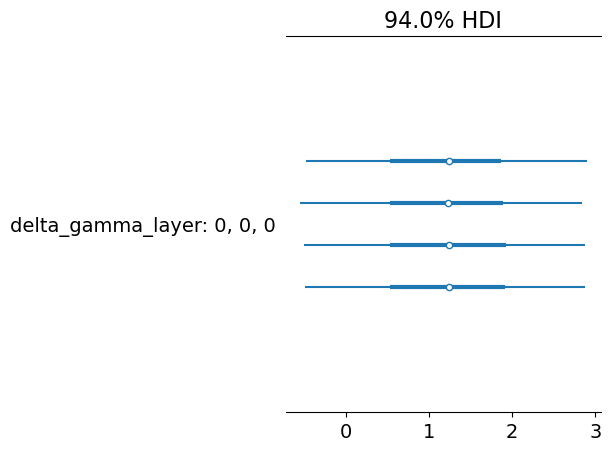

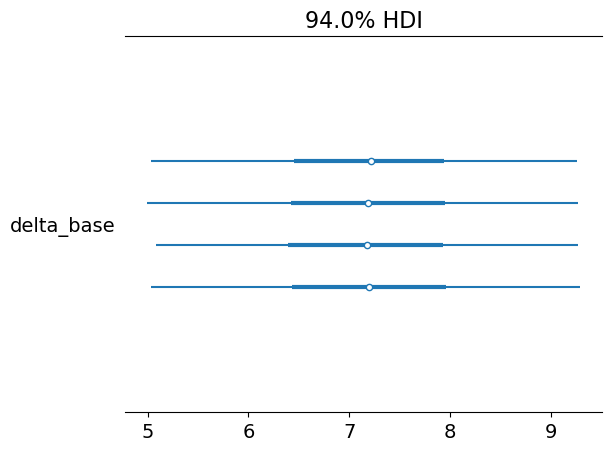

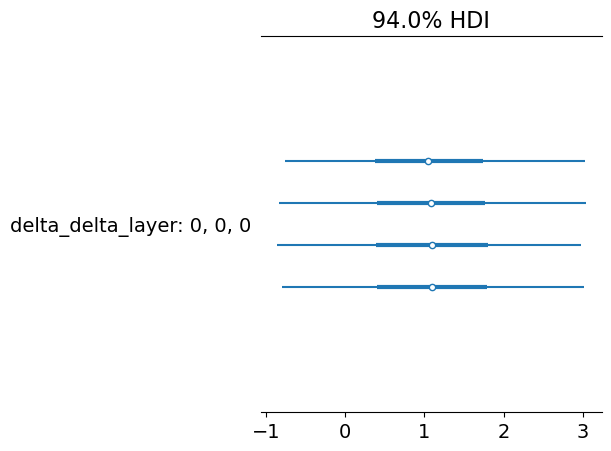

In [10]:
t = trace
az.plot_forest(t,var_names=['nu_max'])
az.plot_forest(t,var_names=['gamma_base'])
az.plot_forest(t,var_names=['^delta_gamma'], filter_vars='regex')
az.plot_forest(t,var_names=['delta_base'])
az.plot_forest(t,var_names=['^delta_delta'], filter_vars='regex')


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

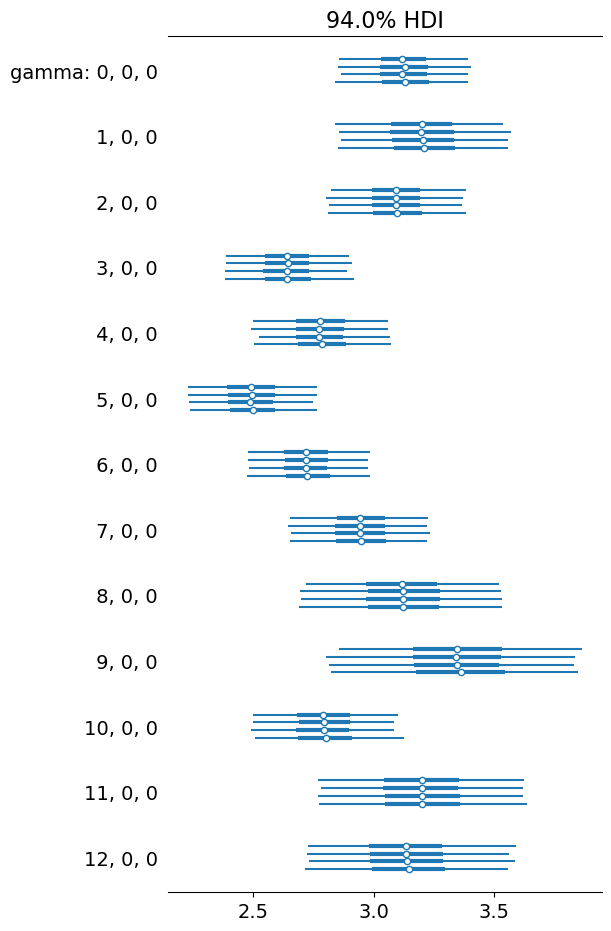

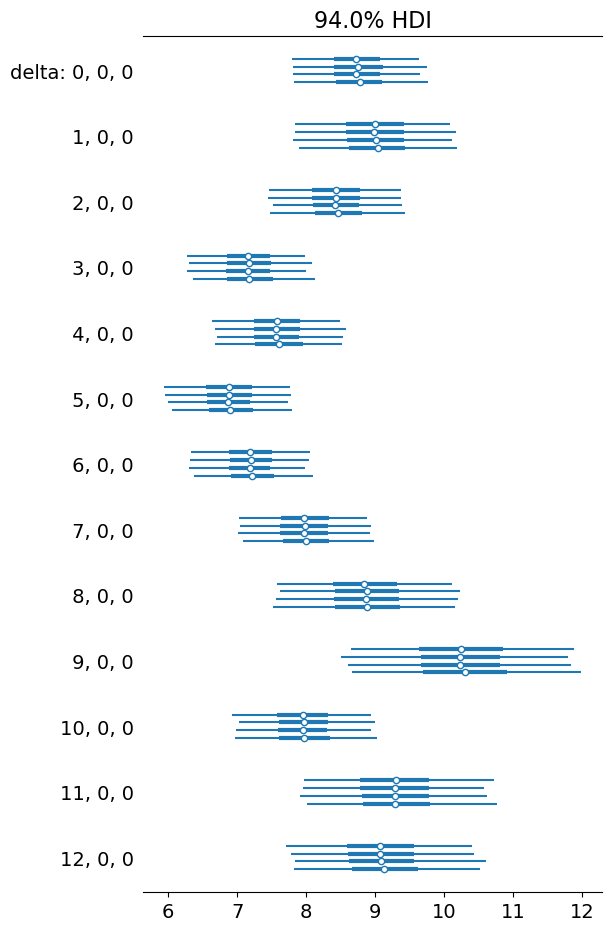

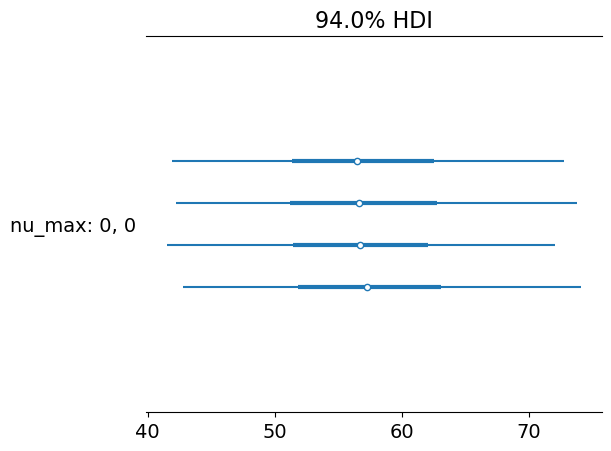

In [11]:
az.plot_forest(t,var_names=['gamma'])
az.plot_forest(t,var_names=['delta'])
az.plot_forest(t,var_names=['nu_max'])

In [12]:
delta_range = [0,10]
gamma_range = [0,4]
chi = create_phaseSpace(steps=101,gamma_range=gamma_range,delta_range=delta_range,nu_max=results['nu_max']['mean'][0,0])

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/DM_theory/functions.py:12: RuntimeWarning: invalid value encountered in sqrt
  return nu_max * np.exp( - (gamma**2 * delta**2 - 2*(gamma**2 - 1) + gamma * delta *np.sqrt(gamma**2 * delta**2 - 4*(gamma**2 - 1))) / (4 * (gamma**2 - 1)**2))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/DM_theory/functions.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return nu_max * np.exp( - (gamma**2 * delta**2 - 2*(gamma**2 - 1) + gamma * delta *np.sqrt(gamma**2 * delta**2 - 4*(gamma**2 - 1))) / (4 * (gamma**2 - 1)**2))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/DM_theory/functions.py:12: RuntimeWarning: invalid value encountered in true_divide
  return nu_max * np.exp( - (gamma**2 * delta**2 - 2*(gamma**2 - 1) + gamma * delta *np.sqrt(gamma**2 * delta**2 - 4*(gamma**2 - 1))) / (4 * (gamma**2 - 1)**2))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/DM_theory/functions.py:15: RuntimeWarning: 

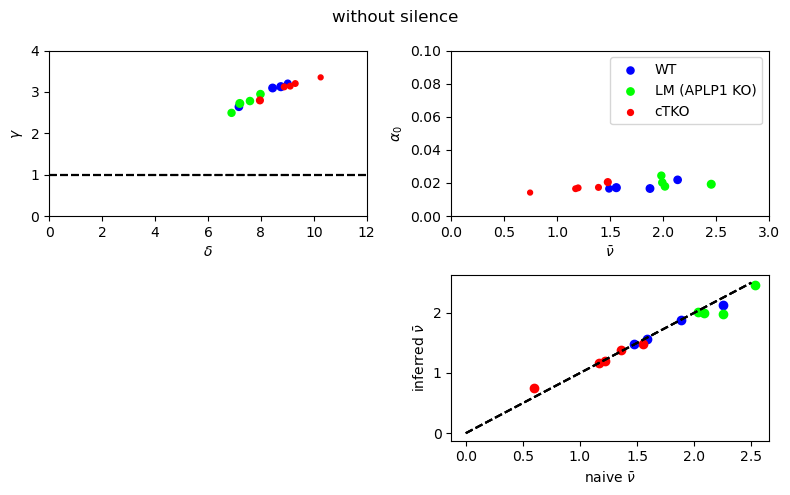

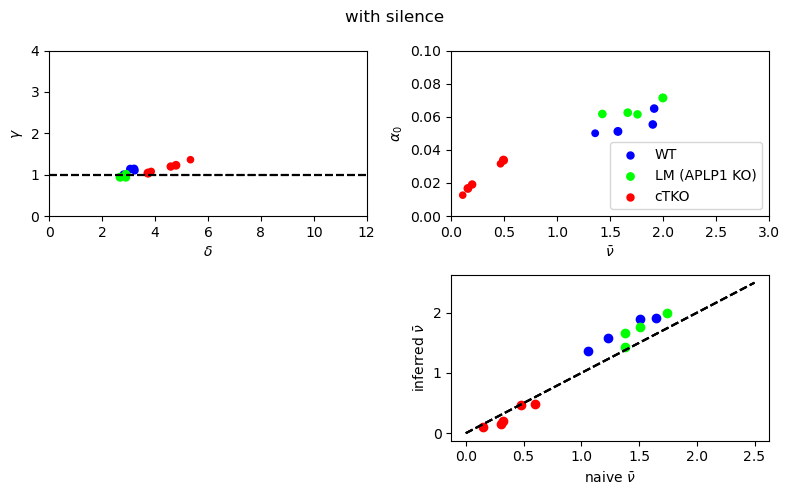

In [33]:
def plot_results(mP,results,title):
    
    gamma = results['gamma']['mean']
    delta = results['delta']['mean']
    nu_max = results['nu_max']['mean']
    
    tau_m = 0.01
    tau_I = get_tau_I(nu_max,tau_m=tau_m)
    #print(f'$\displaystyle\\tau_I = {tau_I}$')
    nu_mean = get_nu_bar(gamma=gamma,delta=delta,nu_max=nu_max)

    q = nu_max**2 * gamma / np.sqrt(gamma**2 + 2) * np.exp(-delta**2 / (2+gamma**2))
    J_0 = -1 * tau_m
    alpha_0 = np.sqrt(J_0**2 * ( nu_mean/ (2 * gamma**2 * (tau_I + tau_m)) - q))

    #fig,ax = plt.subplots(mP._num_clusters,2,figsize=(15,3*mP._num_clusters))
    fig,ax = plt.subplots(2,2,figsize=(8,5*mP._num_clusters))
    #ax = ax if mP._num_clusters>1 else [ax]
    
    if len(mP.types)>2:
        col = np.array([[0,0,1],[0,1,0],[1,0,0]])
    else:
        col = np.array([[0,0,1],[1,0,0]])
    
    for c in range(mP._num_clusters):
        for i,t in enumerate(mP.types):
            for l in range(mP._num_layers):
                co = col[i]*(l+3)/(mP._num_layers+2)
                idx = mP.type == i
                label = f'{mP.types[i]}'
                if mP._num_layers>1:
                    label += f' (L{l})'
                if mP._num_clusters>1:
                    label += f' c{c}'
                
                ax[c][0].axhline(1,color='k',linestyle='--')
                ax[c][0].scatter(delta[idx,l,c],gamma[idx,l,c],s=1+30*np.sqrt(results['N'][idx,l,c]/np.max(results['N'][...])),color=co,label=label)
                ax[c][1].scatter(np.squeeze(nu_mean[idx,l,c]),np.squeeze(alpha_0[idx,l,c]),s=1+30*np.sqrt(results['N'][idx,l,c]/np.max(results['N'][...])),color=co,label=label)
                ax[1][1].plot([0,2.5],[0,2.5],'k--')
                ax[1][1].scatter(np.squeeze(results['fr'][idx,...]),np.squeeze(nu_mean[idx,l,c]),color=co)
        plt.setp(ax[c][1],xlim=[0,3],ylim=[0,0.1],
            xlabel='$\\bar{\\nu}$',ylabel='$\\alpha_0$')
        plt.setp(ax[c][0],xlim=[0,12],ylim=[0,4],
            xlabel='$\\delta$',ylabel='$\\gamma$')
        plt.setp(ax[1][1],xlabel='naive $\\bar{\\nu}$',ylabel='inferred $\\bar{\\nu}$')
        ax[c][1].legend()
    plt.suptitle(title)
    ax[1][0].remove()
    plt.tight_layout()
    plt.show()

plot_results(mP,results,'without silence')
plot_results(mP_withSilent,results_silent,'with silence')
#plot_results(mP_Ca,results_Ca,'Ca imaging')

/tmp/ipykernel_115421/216928880.py:2: RuntimeWarning: Mean of empty slice
  firingrate = np.nanmean(mP_Ca.spikes_raw,axis=(3,))


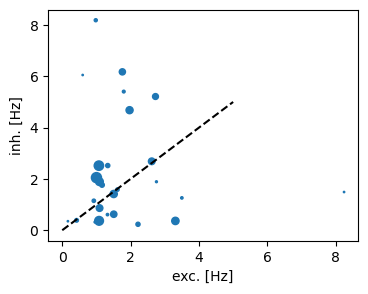

In [22]:
mP_Ca.spikes_raw.shape
firingrate = np.nanmean(mP_Ca.spikes_raw,axis=(3,))
plt.figure(figsize=(4,3))
plt.scatter(firingrate[:,:,0],firingrate[:,:,1],s=results_Ca['N'][:,:,0])
plt.setp(plt.gca(),xlabel='exc. [Hz]',ylabel='inh. [Hz]')
plt.plot([0,5],[0,5],'k--')
plt.show()

In [23]:
### ISSUES ###
#plots are not fitting to silent neurons
# this currently implements an excitatory population, only (without inhib or anything else...)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

#def show_results(mP,trace,results):

res = results
mP_ = mP
t = trace
l = 0
c = 0

plt.ion()
steps=101

nu_max = np.squeeze(res['nu_max']['mean'][l,c])
fig = make_subplots(rows=2, cols=1)

cols = ['rgb(0,0,155)','rgb(155,0,0)','rgb(0,155,0)']
col_array = [cols[idx] for idx in mP_.type]

fig.add_trace(
    go.Heatmap(z=chi,
              x=np.linspace(*delta_range,steps),
              y=np.linspace(*gamma_range,steps),
              zmin=0,zmax=3.5,
              colorscale='YlOrRd',
              #labels={'x':'$\delta$','y':'$\gamma$','color':'$\chi$'}
              ),
    row=1,col=1
)

#delta_x, gamma_y = np.meshgrid(np.linspace(*delta_range,steps), np.linspace(*gamma_range,steps), indexing='xy')
#fig.add_trace(
#    go.Heatmap(z=gamma_y,
#              x=np.linspace(*delta_range,steps),
#              y=np.linspace(*gamma_range,steps),
#              zmin=0,zmax=3.5,
#              colorscale='YlOrRd',
#              #labels={'x':'$\delta$','y':'$\gamma$','color':'$\chi$'}
#              ),
#    row=1,col=1
#)

fig.add_trace(
    go.Scatter(x=res['delta']['mean'][...,l,c], y=res['gamma']['mean'][...,l,c],
        error_x=dict(
            type='data', # value of error bar given in data coordinates
            array=res['delta']['std'][...,l,c],
            visible=True),
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=res['gamma']['std'][...,l,c],
            visible=True),
        mode='markers',
        marker={'size':np.sqrt(res['N'][...,l,c])+5, 'color': col_array},
        name='empirical data',
        legendgroup='1'),
    row=1,col=1,
)
scatter = fig.data[1]

#delta = res['delta']['mean'][0,1,0]
#gamma = res['gamma']['mean'][0,1,0]
#print(delta)
#print(res['delta']['mean'])

hist_data = mP_.spikes_raw[0,~np.isnan(mP_.spikes_raw[0,...])]
hist_data = hist_data[hist_data>0]

steps_distr = 10001
x_arr = np.linspace(1/steps_distr,nu_max,steps_distr)

for ll in range(mP_._num_layers):
    
    l_col = (ll+2)/(mP_._num_layers+1)
    col_line = f'rgb({int(l_col*255)},0,0)'
    col_hist = f'rgb(0,{int(l_col*255)},0)'
    fig.add_trace(
        go.Line(x=x_arr,y=p_nu(x_arr,res['gamma']['mean'][0,ll,c],res['delta']['mean'][0,ll,c],nu_max),
            name='distribution',
            legendgroup='2',
            line=dict(color=col_line),
           ),
        row=2,col=1
    )

    fig.add_trace(
        go.Histogram(x=hist_data, 
                    histnorm='probability',
                    xbins=dict(
                        start=-0.5,
                        end=10.5,
                        size=0.5
                    ),
             name='empirical',
             legendgroup='2',
             marker_color=col_hist
        ),
        row=2,col=1
    )

fig.update_xaxes(range=[-0.5, 10.5],row=2,col=1)
fig.update_yaxes(range=[0, 1.],row=2,col=1)


global prev_idx
prev_idx = None

#def update_point(trace, points, selector):
def update_point(idx):
    #print(idx)
    col = list(scatter.marker.color)
    global prev_idx
    if prev_idx:
        col[prev_idx] = col_array[prev_idx]

    #if len(points.point_inds):
    if not idx==None:
        #idx = points.point_inds[0]
        #for i in points.point_inds:
        col[idx] = '#bae2be'
        with fig.batch_update():
            scatter.marker.color = col
        
        for ll in range(mP_._num_layers):
            
            #print(f'gamma: {res["gamma"]["mean"][idx,l,0]}\n \
            #    delta: {res["delta"]["mean"][idx,l,0]} \n \
            #    nu_max: {nu_max}')
            print(idx,ll,c)
            fig.data[2+ll*2].update(y=p_nu(x_arr,res['gamma']['mean'][idx,ll,c],res['delta']['mean'][idx,ll,c],res['nu_max']['mean'][ll,c])*0.5)
            #idx = points.point_inds[0]
            prev_idx = idx

            hist_data = mP_.spikes_raw[idx,ll,~np.isnan(mP_.spikes_raw[idx,ll,...])]
            hist_data = hist_data[hist_data>0]
            #print(hist_data)

            fig.data[3+ll*2].update(x=hist_data)

#    nu_peak = get_nu_peak(gamma,delta,nu_max)
#    ax[1].set_title("peak @ {:.2f}Hz, chi: {:.2f}".format(nu_peak,chi))
#    mean_val = ax[1].vlines(get_nu_bar(gamma,delta,nu_max),0,5)
#    peak_val = ax[1].vlines(get_nu_peak(gamma,delta,nu_max),0,5,color='r')

    fig.show()

#fig = go.FigureWidget(fig)
#scatter = fig.data[1]
#scatter.on_click(update_point)

fig.update_layout(
    height=800, 
    width=800, 
    #title_text="Empirical data of firing rate distributions",
    legend_tracegroupgap = 360,
    #coloraxis_colorbar_x=-0.15,
)
#fig.update_layout(coloraxis_colorbar_x=-0.5)
print(fig.data[0].colorbar)
fig.data[0].colorbar.x=0.05
fig.data[0].colorbar.y=0.9
fig.data[0].colorbar.len=0.3
fig.data[0].colorbar.title='$\chi$'

#fig
idx_widget = widgets.IntSlider(0,min=0,max=mP._num_animals-1,step=1,orientation='horizontal',description=r'i')
widgets.interactive(update_point,idx=idx_widget)


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/DM_theory/functions.py:6: RuntimeWarning:

divide by zero encountered in true_divide

/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




heatmap.ColorBar()


interactive(children=(IntSlider(value=0, description='i', max=12), Output()), _dom_classes=('widget-interact',…

In [31]:
def plot_gammaDelta(ax,mP,results):
    #fig,ax = plt.subplots(1,mP._num_clusters,figsize=(12,6))
    try:
        ax[0]
    except:
        ax = [ax]
    
    print('clusters:',mP._num_clusters)
    print(ax)
    for c in range(mP._num_clusters):
        print(c)
        if c>0:
            continue
        for i in range(mP._num_layers):
            for idx,t in enumerate(mP.types):
                idxs = mP.type==idx
                p_label = mP.types[idx]
                #print(idxs)
                #f'layer {i}'
                ax[c].errorbar(results['delta']['mean'][idxs,i,c],results['gamma']['mean'][idxs,i,c],results['delta']['std'][idx,i,c],results['gamma']['std'][idxs,i,c],'o',ms=1,lw=0.5,label=p_label)
                ax[c].scatter(results['delta']['mean'][idxs,i,c],results['gamma']['mean'][idxs,i,c],s=1+2*results['N'][idxs,i,c])
                ax[c].legend()
        
        #ax[c].set_xlabel(r'$\displaystyle \delta$')
        plt.setp(ax[c], xlabel=r"$\displaystyle \delta$", ylabel=r'$\displaystyle \gamma$',
                xlim=[0,12],ylim=[0,4.5])
fig,ax = plt.subplots(1,3,figsize=(15,6))
plot_gammaDelta(ax[0],mP,results)
plot_gammaDelta(ax[1],mP_withSilent,results_silent)
plot_gammaDelta(ax[2],mP_Ca,results_Ca)

clusters: 1
[<AxesSubplot:>]
0
clusters: 1
[<AxesSubplot:>]
0
clusters: 2
[<AxesSubplot:>]
0
1


ValueError: 
\displaystyle \delta
^
Unknown symbol: \displaystyle, found '\'  (at char 0), (line:1, col:1)

<Figure size 1500x600 with 3 Axes>

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(N[:,0,0],N[:,0,1],'o',color=[0,0,0.2],label='L1')
ax.plot(N[:,1,0],N[:,1,1],'o',color=[0,0,1],label='L2')
ax.plot(N[:,2,0],N[:,2,1],'o',color=[0.7,0.7,1],label='L3')
plt.setp(ax,xlabel='excitatory',ylabel='inhibitory')

ax.legend()
plt.show()

In [17]:
df = pd.DataFrame(columns=['animal_idx','layer_idx','cluster_idx','gamma','gamma_std','delta','delta_std'])
#df['animal_idx'] = range(mP._num_animals)
for animal_idx in range(mP._num_animals): 
    for layer_idx in range(mP._num_layers):
        for cluster_idx in range(mP._num_clusters):
            df.loc[len(df)] = {'animal_idx':animal_idx,
                       'layer_idx':layer_idx,
                       'cluster_idx':cluster_idx,
                       'gamma':gamma_mean[animal_idx,layer_idx,cluster_idx],
                       'gamma_std':gamma_std[animal_idx,layer_idx,cluster_idx],
                       'delta':delta_mean[animal_idx,layer_idx,cluster_idx],
                       'delta_std':delta_std[animal_idx,layer_idx,cluster_idx]}
            
df

,animal_idx,layer_idx,cluster_idx,gamma,gamma_std,delta,delta_std
0,0,0,0,3.125234,0.144199,8.750525,0.504853
1,1,0,0,3.204949,0.188919,9.010843,0.611176
2,2,0,0,3.094623,0.150165,8.443057,0.508500
3,3,0,0,2.640272,0.138109,7.167093,0.464728
4,4,0,0,2.778680,0.148461,7.583935,0.497417
5,5,0,0,2.491057,0.141063,6.884670,0.474249
6,6,0,0,2.718820,0.133402,7.198141,0.454571
7,7,0,0,2.941794,0.151567,7.971024,0.504922
8,8,0,0,3.121795,0.221052,8.880839,0.690686
9,9,0,0,3.353310,0.269315,10.262102,0.866444


In [19]:
from empirical.model import *

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib nbagg

steps = 100

gamma_range = [0.5,3.5]
gamma_range = [gamma_range[0]+np.diff(gamma_range)[0]/steps,gamma_range[1]]

delta_range = [2.,8.]
delta_range = [delta_range[0]+np.diff(delta_range)[0]/steps,delta_range[1]]

nu_range = [0,100]
nu_max = 60.

delta_x, gamma_y = np.meshgrid(np.linspace(*delta_range,steps), np.linspace(*gamma_range,steps), indexing='xy')
chi = get_chi(gamma_y,delta_x,nu_max)

fig = px.imshow(chi,origin='lower',aspect='auto',zmin=-2,zmax=5,
                color_continuous_scale='jet',
               x=np.linspace(*delta_range,steps),
               y=np.linspace(*gamma_range,steps),
               labels={'x':'delta','y':'gamma','color':'chi'})
##for i in range(3):

#fig = go.FigureWidget()
#f = fig.add_scatter(x=df['delta'], y=df['gamma'],mode='markers',marker={'size':8, 'symbol':'diamond'})
#scatter = go.Scatter(x=df['delta'], y=df['gamma'],
#                         #error_x=dict(
#                         #   type='data', # value of error bar given in data coordinates
#                         #   array=df['delta_std'],
#                         #   thickness=0.5,
#                         #   visible=True),
#                         #error_y=dict(
#                         #   type='data', # value of error bar given in data coordinates
#                         #   array=df['gamma_std'],
#                         #   thickness=0.5,
#                         #   visible=True),
#                         mode='markers',
#                         #marker={'size':8, 'symbol':'diamond'}
#              )

#scatter = f.data[0]
#print(scatter)
#colors = ['#a3a7e4'] * 100
#scatter.marker.color = colors
#scatter.marker.size = [15] * 100

#px.scatter(df, x='delta', y='gamma')

# create our callback function
def update_point(trace, points, selector):
    display('hey')
    print('ho')
    print(trace)
    print(points)
    print(selector)
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


fig.data[0].on_click(update_point)
#f.show()
#data=[scatter]
#layout = go.Layout(title='Activity Heatmap')

#figure = go.Figure(data=data, layout=layout)

#f2 = go.FigureWidget(figure)
#f2.on_click(update_point)
#f2.show()

#fig.add_trace(f)
#fig = 
#fig.layout.hovermode = 'closest'
#fig.add_trace(f)
#fig.show()
display(fig)

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/empirical/model.py:16: RuntimeWarning:

divide by zero encountered in log10



In [12]:
help(f.data[0].on_click)

Help on method on_click in module plotly.basedatatypes:

on_click(callback, append=False) method of plotly.graph_objs._scatter.Scatter instance
    Register function to be called when the user clicks on one or more
    points in this trace.
    
    Note: Callbacks will only be triggered when the trace belongs to a
    instance of plotly.graph_objs.FigureWidget and it is displayed in an
    ipywidget context. Callbacks will not be triggered on figures
    that are displayed using plot/iplot.
    
    Parameters
    ----------
    callback
        Callable function that accepts 3 arguments
    
        - this trace
        - plotly.callbacks.Points object
        - plotly.callbacks.InputDeviceState object
    
    append : bool
        If False (the default), this callback replaces any previously
        defined on_click callbacks for this trace. If True,
        this callback is appended to the list of any previously defined
        callbacks.
    
    Returns
    -------
    None
    

In [48]:
import plotly.graph_objects as go
from plotly.callbacks import Points, InputDeviceState
points, state = Points(), InputDeviceState()
    
def click_fn(trace, points, state):
     inds = points.point_inds
     # Do something
    
trace = go.Scatter(x=[1, 2], y=[3, 0])
trace.on_click(click_fn)

<ul>
    <li>mark plots of animals, layers, clusters accordingly</li>
    <li>define interaction with plot-points: click to obtain empirical data + inferred best fit of firing rate distribution</li>
</ul>

In [104]:
total_gamma = trace.posterior['gamma_base'].mean(axis=1) + \
    trace.posterior['delta_gamma_animal'].mean(axis=1) + \
    trace.posterior['delta_gamma_cluster'].mean(axis=1) + \
    trace.posterior['delta_gamma_layer'].mean(axis=1)
total_gamma.shape

(4, 4, 1, 1, 1, 1, 1, 1, 1, 1)

/tmp/ipykernel_19669/3087850351.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


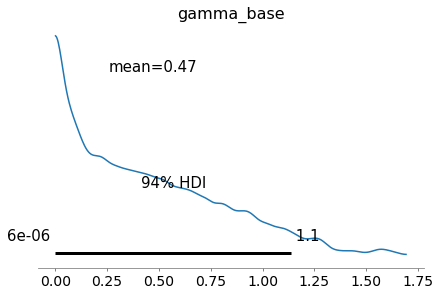

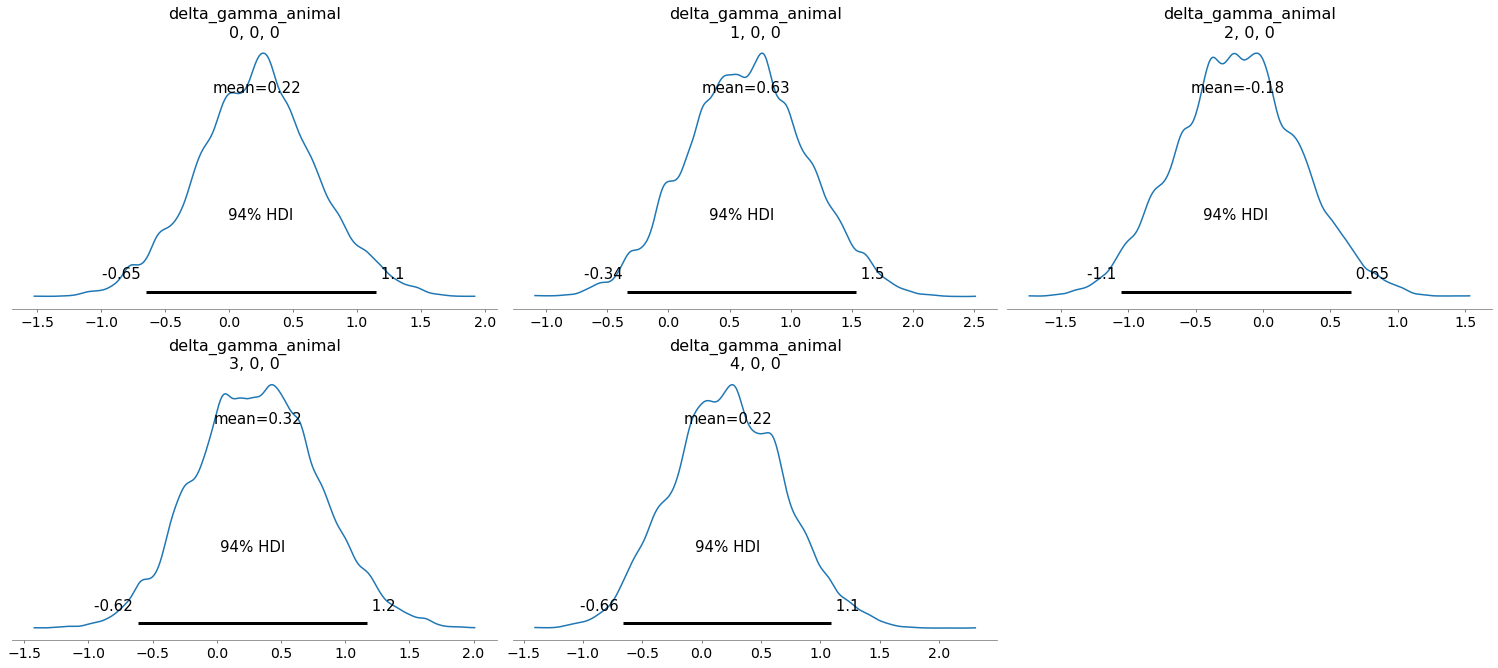

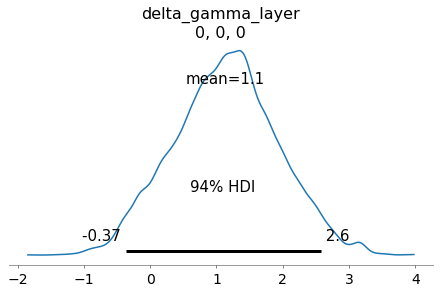

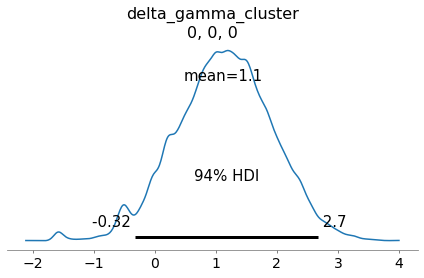

In [76]:
varName = 'gamma'
#az.plot_posterior(trace,var_names=[f'{varName}'])
az.plot_posterior(trace,var_names=[f'{varName}_base'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_animal'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_layer'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_cluster'],filter_vars='regex')
plt.tight_layout()

In [77]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"delta_gamma_animal[0,0,0]",0.22,0.47,-0.65,1.15,0.01,0.01,1295.87,1115.14,1.00
"delta_gamma_animal[1,0,0]",0.63,0.49,-0.34,1.53,0.01,0.01,1235.11,1769.29,1.00
"delta_gamma_animal[2,0,0]",-0.18,0.45,-1.05,0.65,0.01,0.01,1216.28,1714.81,1.00
"delta_gamma_animal[3,0,0]",0.32,0.48,-0.62,1.17,0.01,0.01,1257.36,1174.28,1.00
"delta_gamma_animal[4,0,0]",0.22,0.47,-0.66,1.09,0.01,0.01,1321.07,2479.00,1.00
"delta_gamma_layer[0,0,0]",1.14,0.79,-0.37,2.57,0.02,0.02,1360.78,1153.70,1.00
"delta_gamma_cluster[0,0,0]",1.13,0.80,-0.32,2.67,0.02,0.02,1318.56,719.41,1.00
"delta_delta_animal[0,0,0]",-0.09,0.69,-1.44,1.15,0.02,0.01,1489.19,1099.25,1.00
"delta_delta_animal[1,0,0]",1.79,0.79,0.27,3.25,0.01,0.01,2900.27,3322.01,1.00
"delta_delta_animal[2,0,0]",-1.13,0.59,-2.18,0.02,0.01,0.01,2120.97,4416.05,1.00


In [78]:
model.deterministics

[sigma_gamma ~ HalfNormal,
 gamma_base ~ HalfNormal,
 gamma ~ Deterministic,
 sigma_delta ~ HalfNormal,
 delta_base ~ HalfNormal,
 delta ~ Deterministic]

(array([431., 126., 129.,  90.,  62.,  49.,  30.,  28.,  20.,   9.,  15.,
          5.,  13.,   8.,   4.,   5.,   3.,   4.,   1.,   4.,   1.,   1.,
          0.,   3.,   1.,   5.,   1.,   2.,   2.,   1.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. ]),
 <BarContainer object of 30 artists>)

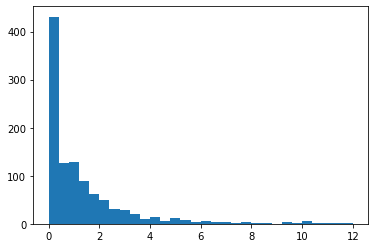

In [110]:
plt.hist(mP.spikes,np.linspace(0,12,31))